In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
The OpenIFS coupling preparation tool (ocp-tool) prepares input files for a
coupled OpenIFS-FESOM2 or OpenIFS-NEMO climate simulation


To this end it performs three tasks:
1) Modifing the OpenIFS input files to fit the land sea mask and soil types
    to the ocean models land sea mask
2) Generating appropriate OASIS3-MCT input files to fit the modified land
    sea mask
3) Modifing the runoff-mapper drainage basin and arrival point file to fit
    the modified land sea mask


To function, the script therefore needs the following input files:
1) Grid information txt file for the full Gaussian grid of the chosen
    trucation number. This fileset comes with the tool.
2) Grid information txt file for the reduced Gaussian grid This fileset comes
    with the tool.
3) OpenIFS gridpoint input file (ICMGG${EXP_NAME}INIT) containing default
    land-sea mask that will be modified. can be requested from ECMWF:
    openifs-support@ecmwf.int
4) Runoff-mapper input files (runoff_maps.nc) file containing default
    drainage basin and arrival point fields. This fileset is part of the
    EC-Earth input files and available from:


If you have trouble getting this tool to work in your python environment
you may try loading the environment.yaml with:
    conda env create -f environment.yml


@author: Jan Streffing (jan.streffing@awi.de), August 2019
'''

from __future__ import division

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import gribapi
import csv
import math
import netCDF4 as nc
from pathlib import Path


import pyfesom2 as pf
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from shutil import copy2

#-----------------------------------------------------------------------------
# Setup
#-----------------------------------------------------------------------------

# Setting constants
earth_radius = 6371. * 1e3 #[m]
longline = ' \n ==================================================  \n'


#-----------------------------------------------------------------------------
# Function definitions
#-----------------------------------------------------------------------------


def read_grid_file(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, exp_name_oifs='hagw', input_path_oifs='input/openifs_input_default/',verbose=False):
    '''
    This function reads the reduced gaussian gridfile and returns it as a raw
    field
    '''
    if truncation_type == 'linear':
        # linear truncation (T = NN * 2 - 1)
        NN = res_num/2 + 0.5
        grid_txt = '%s/n%d_reduced.txt' % (input_path_reduced_grid, NN)
        
    elif truncation_type == 'cubic-octahedral':
        # cubic octahedral truncation (T = NN - 1)
        NN = res_num + 1
        grid_txt = '%s/o%d_reduced.txt' % (input_path_reduced_grid, NN)

    #print(' Read grid from file: %s ' % (grid_txt,) )

    print(longline)
    print(' Reading OpenIFS gridfile for T%d ' % (res_num))
    print(longline)
    
    if os.path.isfile(grid_txt):
       fin = open(grid_txt, 'r')
       print(' Read grid from file: %s ' % (grid_txt,) )
    else:
       icmfile = '%s/ICMGG%sINIT' % (input_path_oifs, exp_name_oifs) 
       grid_txt = read_grid_from_icmgg(icmfile, NN, truncation_type)
       fin = open(grid_txt, 'r')
       print(' Read grid from file: %s ' % (icmfile,) )

       
    lines = fin.readlines()
    return (lines, NN)


def read_grid_from_icmgg(icmfile, NN, truncation_type):
   """
   Read lon, lats from grib template file
   Uses CDO to get grid description from a GRIB file
   """
   
   latitudes = []
   nlongitudes = []
   
   file=icmfile
   
   # write grid description to file
   # only need to do this once
   breakpoint()
   os.system('cdo griddes %s > griddes.txt' % (file,))
   
   # read data from text file
   f = open('griddes.txt','r')
   lines = f.readlines()   
   for i in range(0,len(lines)):      
      if 'yvals' in lines[i]:
         yline = i
      elif 'rowlon' in lines[i] or 'reducedPoints' in lines[i]:
         rline = i
   
   # read from yvals until we hit rowlon   
   for i in range(yline,len(lines)):
      line = lines[i]
      print(line)
      if 'rowlon' in line or 'reducedPoints' in line:
         break
      if i == yline:
         # convert data to floats
         tmp_lat = [float(lat) for lat in line.split()[2:]]
      else:
         tmp_lat = [float(lat) for lat in line.split()]
      # append data to latitudes list
      for lat in tmp_lat: latitudes.append(lat) 
      
   for i in range(rline,len(lines)):
      line = lines[i]
      if 'scanningMode' in line: 
         break 
      if i == rline:
         # convert to integers
         tmp_nlon = [int(nlon) for nlon in line.split()[2:]]
      else:
         tmp_nlon = [int(nlon) for nlon in line.split()]
      # append data to nlongitudes list
      for nlon in tmp_nlon: nlongitudes.append(nlon) 
         
   f.close()
   
   print('nlon: ',nlongitudes)
   print('lat: ',latitudes)
   
   # Now construct the grid
   lons = []
   lats = []
   for ilat in range(0,len(nlongitudes)):
      
      lat  = latitudes[ilat]
      nlon = nlongitudes[ilat]
      
      lon1  = np.arange(0,360,360./nlon)
      
      for lon in lon1: 
         lons.append(lon)
         lats.append(lat)   
   
   if truncation_type == 'cubic-octahedral':
      ngrid = 'o%d' % (NN,)
      rfile = 'input/gaussian_grids_octahedral_reduced/%s_reduced.txt' % (ngrid,)
      
   elif truncation_type == 'linear':
      ngrid = 'n%d' % (NN,)
      rfile = 'input/gaussian_grids_linear_reduced/%s_reduced.txt' % (ngrid,)
   
   # Write to text file that CDO can use for interpolations
   f = open(rfile,'w')
   f.write('latitude reduced regular latitude \n')
   f.write('number points points \n')
   f.write(' ------- ------- ------- ---------- \n' )
   
   for ilat in range(0,len(nlongitudes)):
      f.write('%d %d %d %f \n' % (ilat+1, nlongitudes[ilat], len(nlongitudes)*2, latitudes[ilat]))
   f.close()
   
   return rfile


def extract_grid_data(lines,verbose=False):
    '''
    This function takes the raw reduced gaussian coordinate list and returns
    coordinate and neighbour distrance lists for latitude and
    longitude of every grindpoint, as well as the number of latitudes and
    longitudes
    '''
    gridsize = 0
    lons_list       = []  # longitudes of each gridpoint
    lats_list       = []  # latitudes of each gridpoint
    numlons_list    = []  # number of longitude points for each latitude
    dlon_list       = []  # longitude distance in degree at each latitude
    lat_list        = []  # list of latitudes

    for line in lines[3:]:
        # read latitude number, number of longitudes for red. Gaussian and regular Gauss grids
        # convert from strings to floats
        if verbose:
            print(line)
        _, red_points, _, lat = (float(z) for z in line.split())

        # longitudes for reduced Gaussian grid
        dlon = float(360)/red_points
        #The -0.000000001 deals with rounding errors a la 360./644*360=359.9999999999994
        lons = np.arange(0, 360-0.000000001, dlon)
        numlons_list.append(int(red_points))
        dlon_list.append(dlon)
        lat_list.append(lat)

        # set longitudes/latitudes for reduced Gaussian grid on this latitude
        lons_list.extend(lons)
        lats_list.extend([lat]*len(lons))
        gridsize += len(lons)

    return (lons_list, lats_list, numlons_list, dlon_list, lat_list)


def calculate_corner_latlon(lats_list, lons_list, numlons_list, dlon_list,
                            lat_list,verbose=False):
    '''
    This function calculates the latitude and longitude values at the corners
    of the gridcells based on the center values. It also saves both the corner
    and center coordinates into a float32 arrays with oasis3-mct compatible
    structure
    '''

    # OASIS requires grids to be 2D, but IFS grid is 1D, so we give it an
    # extra dimension.
    center_lons = np.array(lons_list, dtype='float32')[np.newaxis, :]
    center_lats = np.array(lats_list, dtype='float32')[np.newaxis, :]
    nx = center_lons.shape[1]
    ny = 1

    print(' Size of grid: nx = %d, ny = %d' % (nx, ny))

    # Now we calculate longitudes/latitudes of corner points for each grid cell
    crn_lons = np.zeros((4, ny, nx))
    crn_lats = np.zeros((4, ny, nx))

    kk = 0 # cell index
    for ii, ni in enumerate(numlons_list):
        '''
        Layout of the four corners

        2 ---------- 1
        |            |
        |            |
        |            |
        3 -----------4

        ^ y
        |
        |
        |
        ----> x
        '''

        dlon = dlon_list[ii]
        lat  = lat_list[ii]
        lons = np.arange(0, 360, dlon)

        #     NP --- j=1 ---|--- j=2 ---|--- j=3 ---|--- j=n --- SP
        #                           <-dlat_n-> <-dlat_s->

        # if first latitude, the previous point was north pole
        if ii == 0:
            dlat_n = 90 - lat
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # if last latitude, the next point is south pole
        elif ii == len(numlons_list)-1:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = lat + 90

        else:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = (lat - lat_list[ii+1]) / 2.

        for jj in range(ni):
            # corner 1: north-east
            crn_lons[0, 0, kk] = lons[jj] + dlon/2.
            crn_lats[0, 0, kk] = lat + dlat_n

            # corner 2: north-west
            crn_lons[1, 0, kk] = lons[jj] - dlon/2.
            crn_lats[1, 0, kk] = lat + dlat_n

            # corner 3: south-west
            crn_lons[2, 0, kk] = lons[jj] - dlon/2.
            crn_lats[2, 0, kk] = lat - dlat_s

            # corner 4: south-east
            crn_lons[3, 0, kk] = lons[jj] + dlon/2.
            crn_lats[3, 0, kk] = lat - dlat_s

            kk += 1

    # Make sure that longitudes are [-180, 180] and not [0, 360]
    center_lons = np.where( center_lons > 180, center_lons - 360, center_lons )
    crn_lons    = np.where( crn_lons > 180, crn_lons - 360, crn_lons )
    return (center_lats, center_lons, crn_lats, crn_lons)


def calculate_area(center_lons, numlons_list, dlon_list, lat_list,verbose=False):
    '''
    This function calculates the area of the gridcells based on the center
    values and saves them into a float32 array with oasis3-mct compatible
    structure
    '''

    # OASIS requires grids to be 2D, but IFS grid is 1D, so we give it an
    # extra dimension.
    nx = center_lons.shape[1]
    ny = 1

     # Now we calculate the cell area of each cell
    gridcell_area = np.zeros((ny, nx))

    kk = 0 # cell index
    for ii, ni in enumerate(numlons_list):

        dlon = dlon_list[ii]
        lat  = lat_list[ii]
        lons = np.arange(0, 360, dlon)

        #     NP --- j=1 ---|--- j=2 ---|--- j=3 ---|--- j=n --- SP
        #                           <-dlat_n-> <-dlat_s->

        # if first latitude, the previous point was north pole
        if ii == 0:
            dlat_n = 90 - lat
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # if last latitude, the next point is south pole
        elif ii == len(numlons_list)-1:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = lat + 90

        else:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # Grid cell areas in m2 width in latitude of cell is dlat_n + dlat_s
        dx = dlon * np.pi/180. * earth_radius * np.cos( np.pi/180. * lat )
        dy = (dlat_n + dlat_s) * np.pi/180. * earth_radius
        area = dx * dy

        for jj in range(ni):
            gridcell_area[0, kk] = area
            kk += 1

    return(gridcell_area)


def read_fesom_grid(input_path_oce, grid_name_oce, fesom_grid_file_path, interp_res = 'r3600x1801', 
                  cavity=False, force_overwrite_griddes=False, verbose=False):
    
    print(longline)
    print(' Using cdo and nco to interpolate from ocean to OpenIFS land sea mask')
    
    # Switch to work folder
    current_dir=os.getcwd()
    os.chdir(input_path_oce)

    # execute the command

    if os.path.exists(fesom_grid_file_path) and force_overwrite_griddes==False:
        print(f"Using existing grid description file '{fesom_grid_file_path}'")
        cmd = './prep_fesom.sh '+fesom_grid_file_path+' '+grid_name_oce+' '+interp_res+' ../openifs_input_default/ICMGG'+exp_name_oifs+'INIT '+str(cavity)
    else:
        if os.path.exists(fesom_grid_file_path):
            print(f"The file '{fesom_grid_file_path}' exists but force_overwrite_griddes=True means we make a create one anyway via pyfesom2")        
        if force_overwrite_griddes==True:
            print(f"The file '{fesom_grid_file_path}' does not exist. Attempting to create via pyfesom2")
        griddir=os.path.dirname(fesom_grid_file_path)
        grid = pf.read_fesom_ascii_grid(griddir=griddir, cavity=cavity)
        pf.write_mesh_to_netcdf(grid, ofile=input_path_oce+'/mesh.nc', overwrite=True, cavity=cavity)
        cmd = './prep_fesom.sh '+input_path_oce+'/mesh.nc'+' '+grid_name_oce+' '+interp_res+' ../openifs_input_default/ICMGG'+exp_name_oifs+'INIT '+str(cavity)
 
    print(cavity)
    print(cmd)
    print(' Reading ocean based land sea mask:', grid_name_oce)
    os.system(cmd)
    mesh=Dataset(input_path_oce+'/'+grid_name_oce+'_oifs.nc',verbose=False)
    os.chdir(current_dir)

    # Print some info about oasis files
    if verbose:
        print(mesh.variables.keys())
    
    
    fesom_lsm = mesh.variables['cell_area']
    fesom_grid_sorted = fesom_lsm[:]
    
    print(longline)
    
    return fesom_grid_sorted


def read_lsm(res_num, input_path_oifs, output_path_oifs, exp_name_oifs, num_fields,verbose=False):
    '''
    This function reads the oifs input file in grib format and save it into a
    list of numpy arrays.
    '''
    print(' Opening Grib input file: %s ' % (input_path_oifs,))
    input_file_oifs = input_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT'
    gid = [None] * num_fields
    gribfield = [None] * num_fields
    with open(input_file_oifs, 'rb') as f:
        keys = ['N', 'shortName']

        for i in range(num_fields):
            gid[i] = gribapi.grib_new_from_file(f)
            if gid[i] is None:
                break

            for key in keys:
                if not gribapi.grib_is_defined(gid[i], key):
                    raise ValueError("Key '%s' was not defined" % key)
                if verbose:
                    print('%s=%s' % (key, gribapi.grib_get(gid[i], key)))

            shortName = gribapi.grib_get(gid[i], 'shortName')

            if shortName == 'lsm':
                lsm_id = i
            if shortName == 'slt':
                slt_id = i
            if shortName == 'cl':
                cl_id = i

            nres = gribapi.grib_get(gid[i], 'N')
            gribfield[i] = gribapi.grib_get_values(gid[i])

    return (gribfield, lsm_id, slt_id, cl_id, gid)





def write_lsm(gribfield_mod, input_path_oifs, output_path_oifs, exp_name_oifs,
              grid_name_oce, num_fields, gid,verbose=False):
    '''
    This function copies the input gribfile to the output folder and modifies
    it by writing the whole gribfield_mod, including the altered land sea mask
    and soil type fields into the new file
    '''

    input_file_oifs = input_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT'
    output_file_oifs = output_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT_' + grid_name_oce
    copy2(input_file_oifs, output_file_oifs)

    with open(output_file_oifs, 'r+b') as f:
        for i in range(num_fields):
            gribapi.grib_set_values(gid[i], gribfield_mod[i])
            gribapi.grib_write(gid[i], f)
            gribapi.grib_release(gid[i])


def plotting_lsm(res_num, lsm_binary_l, lsm_binary_a, center_lats, center_lons,verbose=False):
    '''
    This function plots the final land sea mask
    '''

    fig3 = plt.figure(figsize=(24, 14))
    ax3  = fig3.add_subplot(111)
    xptsa = center_lons[np.round(lsm_binary_a[:, :])<1]
    yptsa = center_lats[np.round(lsm_binary_a[:, :])<1]
    xptsl = center_lons[np.round(lsm_binary_l[:, :])<1]
    yptsl = center_lats[np.round(lsm_binary_l[:, :])<1]
    ax3.scatter(xptsl, yptsl, s=100/res_num, color='red', marker='.', label='New dry points')
    ax3.scatter(xptsa, yptsa, s=200/res_num, marker='.', label='Wet points')
    ax3.legend(loc="lower right")
    figname = 'output/plots/land_points_T%d.png' % (res_num,)
    fig3.savefig(figname, format='png',dpi=600)


def generate_coord_area(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, exp_name_oifs="hagw",verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''

    lines, NN = read_grid_file(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, 
                               exp_name_oifs=exp_name_oifs,verbose=verbose)
    lons_list, lats_list, numlons_list, dlon_list, lat_list = extract_grid_data(lines,verbose=verbose)
    center_lats, center_lons, crn_lats, crn_lons = calculate_corner_latlon(lats_list, lons_list, 
                                                                           numlons_list, dlon_list, 
                                                                           lat_list,verbose=verbose)
    gridcell_area = calculate_area(center_lons, numlons_list, dlon_list, lat_list,verbose=verbose)

    return (center_lats, center_lons, crn_lats, crn_lons, gridcell_area, lons_list, NN)


def process_lsm(res_num, input_path_oifs, output_path_oifs,
                                 exp_name_oifs, grid_name_oce, num_fields,
                                 fesom_grid_sorted, lons_list,
                                 center_lats, center_lons,crn_lats, crn_lons, 
                                 gridcell_area,verbose=False):
    '''
    This function first reads, modifies and finally saves the new land
    sea mask. Every step is mirrored for the soil type file as it has to be
    modified in the exact same locations
    '''

    gribfield, lsm_id, slt_id, cl_id, gid = read_lsm(res_num, input_path_oifs, 
                                                     output_path_oifs, 
                                                     exp_name_oifs, num_fields,verbose=verbose)
    lsm_binary_a, lsm_binary_l, lsm_binary_r, gribfield_mod = modify_lsm(gribfield, 
                                                           fesom_grid_sorted, 
                                                           lsm_id, slt_id, cl_id, 
                                                           lons_list, center_lats, 
                                                           center_lons, crn_lats, crn_lons, 
                                                           gridcell_area,
                                                           verbose=verbose)
    write_lsm(gribfield_mod, input_path_oifs, output_path_oifs, exp_name_oifs, 
              grid_name_oce, num_fields, gid,verbose=verbose)
    return (lsm_binary_a,lsm_binary_l,lsm_binary_r,gribfield_mod)


def write_oasis_files(res_num, output_path_oasis, grid_name_oce, center_lats, center_lons, 
                      crn_lats, crn_lons, gridcell_area, lsm_binary_a ,lsm_binary_l , lsm_binary_r, 
                      NN, input_path_runoff,verbose=False):
    '''
    This function writes the binary masks, areas and grids files for
    oasis3-mct
    For OpenIFS we set up three different grids:
    All have the same lons, lats and areas
    but different land-sea masks

    atmo: Land = 0, Ocean = 1  (for atm->ocn fluxes)
    atmr: Land = 1, Ocean = 0  (for atm->runoff mapper)

    atmf is the fraction of ocean in each cell, but
    IFS always has 1 or 0, so it is the same as atmo.
    '''

    if len(str(NN))>4:
        NN = int(str(NN)[:-1])
    
    for filebase in ['grids', 'areas', 'masks']:
        filename = '%s%s.nc' % (output_path_oasis, filebase)
        print('Writing file: %s ' % (filename,))
        nc = Dataset(filename, 'w', clobber=True)

        # For OpenIFS + NEMO + Runoffmapper we need two atmosphere grids:
        # atmo: used for atm->ocn remapping (to find ocean)
        # atmr: used for atm->runoff remapping (to find land)

        for grids_name in ('{}{:03}'.format(s, int(NN)) for s in ('A', 'L', 'R')):

            # OASIS requires certain names for the dimensions etc
            print(' Write lons, lats, corner points for grid: %s ' % (grids_name,), '(T%s)' % (res_num,))
            xname = 'x_%s' % (grids_name,)
            yname = 'y_%s' % (grids_name,)
            lonname = '%s.lon' % (grids_name,)
            latname = '%s.lat' % (grids_name,)
            nc.createDimension(xname, center_lons.shape[1])
            nc.createDimension(yname, 1)
            id_lon = nc.createVariable(lonname, 'float64', (yname, xname))
            id_lat = nc.createVariable(latname, 'float64', (yname, xname))

            # Not required, but makes grid info more readable
            id_lon.units = 'degrees_east'
            id_lon.standard_name = 'Longitude'
            id_lat.units = 'degrees_north'
            id_lat.standard_name = 'Latitude'

         # Write corner points to grids file
            if filebase == 'grids':
                crnname = 'crn_%s' % (grids_name,)
                cloname = '%s.clo' % (grids_name,)
                claname = '%s.cla' % (grids_name,)
                nc.createDimension(crnname, 4)
                id_clo = nc.createVariable(cloname, 'float64', (crnname, yname, xname))
                id_cla = nc.createVariable(claname, 'float64', (crnname, yname, xname))

         # Write land-sea masks to masks file
            elif filebase == 'masks':
                mskname = '%s.msk' % (grids_name,)
                id_msk = nc.createVariable(mskname, 'int32', (yname, xname))
                id_msk.coordinates = '%s.lat %s.lon' % (grids_name,grids_name)
                id_msk.valid_min = 0.
                id_msk.valid_max = 1

         # Write grid cell area to areas file
            elif filebase == 'areas':
                areaname = '%s.srf' % (grids_name,)
                id_area = nc.createVariable(areaname, 'float64', (yname, xname))
                id_area.coordinates = '%s.lat %s.lon' % (grids_name,grids_name)

            id_lon[:, :] = center_lons[:, :]
            id_lat[:, :] = center_lats[:, :]
            id_lon.valid_min = center_lons.min()
            id_lon.valid_max = center_lons.max()
            id_lat.valid_min = center_lats.min()
            id_lat.valid_max = center_lats.max()

            if filebase == 'grids':
                id_clo[:, :, :] = crn_lons[:, :, :]
                id_cla[:, :, :] = crn_lats[:, :, :]
                id_clo.valid_min = crn_lons.min()
                id_clo.valid_max = crn_lons.max()
                id_cla.valid_min = crn_lats.min()
                id_cla.valid_max = crn_lats.max()

            elif filebase == 'masks':
                if grids_name.startswith('A') :
                    id_msk[:, :] = np.round(lsm_binary_a[:, :])  
                elif grids_name.startswith('L'):
                    id_msk[:, :] = np.round(lsm_binary_l[:, :])
                elif grids_name.startswith('R'):
                    if grid_name_oce == 'ORCA05':
                        id_msk[:, :] = np.abs(np.round(lsm_binary_r[:, :] - 1))
                    else:
                        id_msk[:, :] = np.abs(np.round(lsm_binary_a[:, :] - 1))
                else:
                    raise RuntimeError('Unexpected grid name: {}'.format(grids_name))

            elif filebase == 'areas':
                id_area[:, :] = gridcell_area[:, :]
                id_area.valid_min = gridcell_area.min()
                id_area.valid_max = gridcell_area.max()


        # Copying runoff mapper grids and areas into oasis3-mct files

        input_file_rnf = '%srunoff_%s.nc' % (input_path_runoff, filebase)
        rnffile = Dataset(input_file_rnf, 'r')

        nc.setncatts(rnffile.__dict__)
        for name, dimension in rnffile.dimensions.items():
            nc.createDimension(name, len(dimension) if not dimension.isunlimited() else None)

        for name, variable in rnffile.variables.items():
            var_out = nc.createVariable(name, variable.datatype, variable.dimensions)
            var_out.setncatts({k: variable.getncattr(k) for k in variable.ncattrs()})
            var_out[:] = variable[:]

        rnffile.close()
        nc.close()
        print(' Wrote %s ' % (filename,))

        print(longline)


def modify_runoff_map(res_num, input_path_runoff, output_path_runoff,
                      grid_name_oce, manual_basin_removal,verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''
    input_file_rnf = '%srunoff_maps.nc' % (input_path_runoff,)
    output_file_rnf = output_path_runoff+'srunoff_maps_'+grid_name_oce+'.nc'
    if os.path.exists(output_file_rnf):
        os.remove(output_file_rnf)
    copy2(input_file_rnf, output_file_rnf)

    rnffile = Dataset(output_file_rnf, 'r+')
    print (rnffile.variables.keys())

    drainage = rnffile.variables[u'drainage_basin_id'][:]
    arrival = rnffile.variables[u'arrival_point_id'][:]

    # Set projection
    lons = rnffile.variables[u'lon'][:]
    lats = rnffile.variables[u'lat'][:]

    for basin in manual_basin_removal:

        if basin == 'caspian-sea':
            for lo, lon in enumerate(lons):
                if lon > 46 and lon < 56:
                    for la, lat in enumerate(lats):
                        if lat > 36 and lat < 47:
                            if drainage[la, lo] == -2:
                                drainage[la, lo] = 18
                                arrival[la, lo] = -1
                # adding artifical arrival points in the amazon discharge area
                # to close the global water budget
                if lon > 313 and lon < 314.5:
                    for la, lat in enumerate(lats):
                        if lat > 1 and lat < 2:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 18

        if basin == 'black-sea':
            for lo, lon in enumerate(lons):
                #removing old basin
                if lon > 27 and lon < 43:
                    for la, lat in enumerate(lats):
                        if lat > 40.5 and lat < 48:
                            if drainage[la, lo] == -2:
                                drainage[la, lo] = 23
                                arrival[la, lo] = -1
                # adding new arrival points
                if lon > 25 and lon < 26.5:
                    for la, lat in enumerate(lats):
                        if lat > 38.5 and lat < 41:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 23
                if lon > 23.5 and lon < 25:
                    for la, lat in enumerate(lats):
                        if lat > 38.5 and lat < 41:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 28

    # Fix for Ob arrival
    for lo, lon in enumerate(lons):
        #removing old arrival points
        if lon > 60 and lon < 70:
            for la, lat in enumerate(lats):
                if lat > 60 and lat < 80:
                    if arrival[la, lo] == 13:
                        arrival[la, lo] = 6
        # adding new arrival points
        if lon > 72 and lon < 75:
            for la, lat in enumerate(lats):
                if lat > 65 and lat < 75:
                    if arrival[la, lo] == 6:
                        arrival[la, lo] = 13

    # Fix for Glacial calving maps
    # Antarctica
    for lo, lon in enumerate(lons):
        #removing old arrival points
        for la, lat in enumerate(lats):
            if lat < -55:
                if arrival[la, lo] == 66:
                    arrival[la, lo] = -2

    for lo, lon in enumerate(lons):
        # adding new arrival points
        if lon > 300 and lon < 320:
            for la, lat in enumerate(lats):
                if lat > -70 and lat < -60:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
        if lon > 320 and lon < 360:
            for la, lat in enumerate(lats):
                if lat > -60 and lat < -50:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
        if lon > 170 and lon < 180:
            for la, lat in enumerate(lats):
                if lat > -75 and lat < -65:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
    # Greenland
    for lo, lon in enumerate(lons):
        # adding new arrival points
        if lon > 300 and lon < 310:
            for la, lat in enumerate(lats):
                if lat > 50 and lat < 60:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 1

    # Saving results
    rnffile.variables[u'drainage_basin_id'][:] = drainage
    rnffile.variables[u'arrival_point_id'][:] = arrival
    rnffile.close()

    plotting_runoff(drainage, arrival, lons, lats)

    return (lons, lats)


def plotting_runoff(drainage, arrival, lons, lats,verbose=False):

    # Split data and concatenate in reverse order to turn by 180° to Prime meridian
    ds1, ds2 = np.hsplit(np.squeeze(drainage), 2)
    drainage_cat = np.concatenate((ds2, ds1), axis=1)
    ds1, ds2 = np.hsplit(np.squeeze(arrival), 2)
    arrival_cat = np.concatenate((ds2, ds1), axis=1)

    lons = lons-180
    lon_0 = lons.mean()
    lat_0 = lats.mean()

    m = Basemap(llcrnrlon=-60., llcrnrlat=-10, urcrnrlon=-30., urcrnrlat=20., \
            resolution='l', area_thresh=1000., projection='cyl')

    #Use meshgrid to create 2D arrays from coordinates
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    fig1 = plt.figure(figsize=(12, 8))
    cmap = plt.cm.flag
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))

    lon_0 = lons.mean()
    lat_0 = lats.mean()
    '''
    m = Basemap(llcrnrlon=20., llcrnrlat=30, urcrnrlon=80., urcrnrlat=50., \
            resolution='l', area_thresh=1000., projection='poly', \
            lat_0=0., lon_0=20.)
    #Use meshgrid to create 2D arrays from coordinates
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, drainage_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_caspian_drainage.png'
    fig1.savefig(figname, format='png')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_caspian_arrival.png'
    fig1.savefig(figname, format='png')
    '''

    m = Basemap(llcrnrlon=50., llcrnrlat=40, urcrnrlon=110., urcrnrlat=80., \
            resolution='l', area_thresh=1000., projection='cyl')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, drainage_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_ob_drainage.png'
    fig1.savefig(figname, format='png')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_ob_arrival.png'
    fig1.savefig(figname, format='png')


def modify_runoff_lsm(res_num, grid_name_oce, manual_basin_removal, lons, lats,
                      output_path_oasis,verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''

    # Editing runoff mapper lsm in oasis3-mct masks file
    filename = '%smasks.nc' % (output_path_oasis,)
    oasis = Dataset(filename, 'r+')

    RnfA = oasis.variables[u'RnfA.msk'][:]
    RnfO = oasis.variables[u'RnfO.msk'][:]

    for basin in manual_basin_removal:

        if basin == 'caspian-sea':
            for lo, lon in enumerate(lons):
                if lon > 46 and lon < 56:
                    for la, lat in enumerate(lats):
                        if lat > 36 and lat < 47:
                            RnfA[la, lo] = 0
                            RnfO[la, lo] = 1

    # Saving altered runoff mapper lsm
    oasis.variables[u'RnfA.msk'][:] = RnfA
    oasis.variables[u'RnfO.msk'][:] = RnfO
    oasis.close()



    
    
def modify_lsm(gribfield, fesom_grid_sorted, lsm_id, slt_id, cl_id, lons_list, 
               center_lats, center_lons, crn_lats, crn_lons, gridcell_area,
               verbose=False):
    '''
    This function firstly uses the lake mask to remove lakes from the land sea
    mask and secondly, if set, uses a preselected list of basins to manually
    alter the lsm and slt fields further. It returns both the original mask
    as well as the modified one
    '''
    # Mask with only solid land in correct format for oasis3-mct file
    import copy
    lsm_binary_l = copy.deepcopy(gribfield[lsm_id])
    lsm_binary_l = lsm_binary_l[np.newaxis, :]
    lsm_binary_r = lsm_binary_l.copy()

    # Automatic lake removal with lakes mask
    gribfield_mod = gribfield[:]
    lsm_diff = np.subtract(gribfield_mod[lsm_id][:], fesom_grid_sorted)
    
    # Soil class of removed lakes is set to SANDY CLAY LOAM
    for i in np.arange (0, len(gribfield_mod[slt_id])-1):
        if gribfield_mod[lsm_id][i] <= 0.5 and fesom_grid_sorted[i] >= .99:
            gribfield_mod[slt_id][i] = 6
            gribfield_mod[lsm_id][i] = 1 
            
    for i in np.arange (0, len(gribfield_mod[slt_id])-1):
        if gribfield_mod[lsm_id][i] >= 0.5 and fesom_grid_sorted[i] < .99:
            gribfield_mod[slt_id][i] = 0
            gribfield_mod[lsm_id][i] = 0
            
    #gribfield_mod[lsm_id]=fesom_grid_sorted
    

    
    # Mask with lakes counting as land in correct format for oasis3-mct file
    lsm_binary_a = gribfield_mod[lsm_id]
    lsm_binary_a = lsm_binary_a[np.newaxis, :]

    return (lsm_binary_a,lsm_binary_l, lsm_binary_r, gribfield_mod)


# In[5]:







osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
def read_paleo(paleo_input_path, paleo_var_name, paleo_lat_name, paleo_lon_name, verbose=False):
    """
    Reads a specified variable from a NetCDF file.

    Parameters:
    paleo_input_path (str): Path to the NetCDF file.
    paleo_var_name (str): Name of the variable to read from the file.

    Returns:
    numpy.ndarray: Data array containing the values of the specified variable.
    """
    
    # Open the NetCDF file
    dataset = nc.Dataset(paleo_input_path, 'r')
    
    # Read the data from the variable
    paleo_var = dataset.variables[paleo_var_name][:]
    paleo_lat = dataset.variables[paleo_lat_name][:]
    paleo_lon = dataset.variables[paleo_lon_name][:]
    
    # Close the dataset
    dataset.close()

    if verbose:
        # Set up the map projection and figure
        fig, ax = plt.subplots(figsize=(10, 8),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Plot the land-sea mask
        # Here, assuming the lon and lat are 1D arrays; if 2D, modify accordingly
        mesh_lon, mesh_lat = np.meshgrid(paleo_lon, paleo_lat)
        contour = ax.pcolormesh(mesh_lon, mesh_lat, paleo_var, shading='auto', cmap='viridis')
        
        # Add coastlines for reference
        ax.coastlines()
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Add color bar
        plt.colorbar(contour, ax=ax, orientation='vertical', label='Land-Sea Mask')
        
        # Title and labels
        ax.set_title('Paleo '+ paleo_var_name)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Show the plot
        plt.show()
    
    return paleo_var, paleo_lat, paleo_lon

In [3]:
def split_paleo_lsm(paleo_lsm, paleo_lsm_lat, paleo_lsm_lon, verbose=False):
    """
    Create two masks from a binary land-sea mask array.
    Ocean is represented as 0 and land as 1 in the input array.
    
    Parameters:
    paleo_lsm (numpy.ndarray): Array representing the land-sea mask.
    
    Returns:
    tuple: Two numpy arrays, the first where oceans are 1 and land is NaN,
           and the second where land is 1 and ocean is NaN.
    """
    # Mask where ocean is 1 and land is NaN
    ocean_mask = np.where(paleo_lsm == 0, 1, np.nan)
    
    # Mask where land is 1 and ocean is NaN
    land_mask = np.where(paleo_lsm == 1, 1, np.nan)
    
    if verbose:
        # Set up the map projection and figure
        fig, ax = plt.subplots(figsize=(10, 8),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Plot the land-sea mask
        # Here, assuming the lon and lat are 1D arrays; if 2D, modify accordingly
        mesh_lon, mesh_lat = np.meshgrid(paleo_lsm_lon, paleo_lsm_lat)
        contour = ax.pcolormesh(mesh_lon, mesh_lat, ocean_mask, shading='auto', cmap='viridis')
        
        # Add coastlines for reference
        ax.coastlines()
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Add color bar
        plt.colorbar(contour, ax=ax, orientation='vertical', label='Land-Sea Mask')
        
        # Title and labels
        ax.set_title('Paleo Ocean Mask')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Show the plot
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10, 8),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Plot the land-sea mask
        # Here, assuming the lon and lat are 1D arrays; if 2D, modify accordingly
        mesh_lon, mesh_lat = np.meshgrid(paleo_lsm_lon, paleo_lsm_lat)
        contour = ax.pcolormesh(mesh_lon, mesh_lat, land_mask, shading='auto', cmap='viridis')
        
        # Add coastlines for reference
        ax.coastlines()
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Add color bar
        plt.colorbar(contour, ax=ax, orientation='vertical', label='Land-Sea Mask')
        
        # Title and labels
        ax.set_title('Paleo Land Mask')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Show the plot
        plt.show()
    
    return land_mask, ocean_mask

In [62]:
from pyresample import geometry, kd_tree
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.tri as tri

def remap_paleo_to_openifs(paleo_var, paleo_lat, paleo_lon, openifs_lat, openifs_lon, res_num, verbose=False):
    """
    Remap a paleo variable from a regular grid to an unstructured grid using the pyresample library.
    Optionally plot the results if verbose is True.
    
    Parameters:
    paleo_var (numpy.ndarray): 2D array of the paleo variable to be remapped.
    paleo_lat (numpy.ndarray): 1D array of latitudes for the paleo variable's grid.
    paleo_lon (numpy.ndarray): 1D array of longitudes for the paleo variable's grid.
    openifs_lat (numpy.ndarray): 1D array of latitudes for the target grid.
    openifs_lon (numpy.ndarray): 1D array of longitudes for the target grid.
    verbose (bool): If True, prints additional information and plots the remapping.
    
    Returns:
    numpy.ndarray: The paleo variable remapped to the OpenIFS grid.
    """
    # Create a meshgrid from the 1D latitude and longitude arrays
    paleo_lon_mesh, paleo_lat_mesh = np.meshgrid(paleo_lon, paleo_lat)

    # Define source and target grids for resampling
    source_grid = geometry.SwathDefinition(lons=paleo_lon_mesh, lats=paleo_lat_mesh)
    target_grid = geometry.SwathDefinition(lons=openifs_lon, lats=openifs_lat)
    
    # Resample using kd-tree for nearest neighbor interpolation
    remapped_var = kd_tree.resample_nearest(source_grid, paleo_var, target_grid,
                                      radius_of_influence=5000000,  # large radius for extensive fill
                                      fill_value=None)             # Use None to leave gaps as NaN
    if verbose:
        # Create a figure with an appropriate size
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Generate the meshgrid for the OpenIFS grid coordinates
        lon_grid, lat_grid = np.meshgrid(openifs_lon, openifs_lat)
    
        # Define the coordinate reference system
        crs_proj = ccrs.PlateCarree()

        # Plot the data using the meshgrid
        scatter = ax.scatter(openifs_lon, openifs_lat, c=remapped_var,s=150/res_num, cmap='viridis', transform=ccrs.PlateCarree(), marker='.')
        
        # Set the extent of the plot based on the bounds of the target grid
        ax.set_extent([openifs_lon.min(), openifs_lon.max(), openifs_lat.min(), openifs_lat.max()], crs=crs_proj)
        
        # Add coastlines for context
        ax.coastlines(resolution='10m')
        
        # Add gridlines and labels on the map
        ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
        
        # Add a color bar
        cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
        cbar.set_label('Variable Intensity')
        
        # Set plot title
        ax.set_title("Remapped Paleo Data plotted with scatter")
        # Display the plot
        plt.show()
    
    return remapped_var

 

 Reading OpenIFS gridfile for T159 
 

 Read grid from file: /work/ab0246/a270092/software/ocp-tool/input/gaussian_grids_linear_reduced//n80_reduced.txt 
1 18 320 89.141519 

2 25 320 88.029429 

3 36 320 86.910771 

4 40 320 85.790629 

5 45 320 84.669924 

6 54 320 83.548947 

7 60 320 82.427818 

8 64 320 81.306595 

9 72 320 80.185310 

10 72 320 79.063982 

11 80 320 77.942624 

12 90 320 76.821243 

13 96 320 75.699844 

14 100 320 74.578432 

15 108 320 73.457008 

16 120 320 72.335576 

17 120 320 71.214136 

18 128 320 70.092690 

19 135 320 68.971240 

20 144 320 67.849784 

21 144 320 66.728326 

22 150 320 65.606864 

23 160 320 64.485399 

24 160 320 63.363932 

25 180 320 62.242462 

26 180 320 61.120991 

27 180 320 59.999518 

28 192 320 58.878044 

29 192 320 57.756569 

30 200 320 56.635092 

31 200 320 55.513614 

32 216 320 54.392135 

33 216 320 53.270655 

34 216 320 52.149175 

35 225 320 51.027694 

36 225 320 49.906212 

37 240 320 48.784729 

38 240 320 47.

/work/ab0246/a270092/software/pyfesom2/pyfesom2/ascii_to_netcdf.py:690: RuntimeWarning: invalid value encountered in cast
  var[:] = vals


Horizontal grid description file complete.
You can use this file to set the horizontal grid of a corresponding NetCDF file with 'cdo setgrid,/work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc ifile.nc ofile.nc'.
False
./prep_fesom.sh /work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc CORE2 r360x181 ../openifs_input_default/ICMGGabdaINIT False
 Reading ocean based land sea mask: CORE2
nco is not found in PATH. Loading module...
cdo genycon,r360x181 -selname,cell_area -setgrid,/work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc /work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc weights_cell_area_r360x181.nc


cdo(1) selname: Process started
cdo(2) setgrid: Process started
cdo    gencon: YAC first order conservative weights from unstructured (126858) to lonlat (360x181) grid
cdo(2) setgrid: Processed 2256370 values from 7 variables over 1 timestep.
cdo(1) selname: Processed 126858 values from 7 variables over 1 timestep.
cdo    gencon: Processed 126858 values from 1 variable over 1 timestep [21.60s 205MB].


cdo -L -remap,r360x181,weights_cell_area_r360x181.nc -selname,cell_area -setgrid,/work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc /work/ab0246/a270092/software/ocp-tool/input/fesom_mesh//mesh.nc CORE2_regular.nc


cdo(1) selname: Process started
cdo(2) setgrid: Process started
cdo(2) setgrid: Processed 2256370 values from 7 variables over 1 timestep.
cdo(1) selname: Processed 126858 values from 7 variables over 1 timestep.
cdo    remap: Processed 126858 values from 1 variable over 1 timestep [0.57s 137MB].


ncap2 -O -s 'where(cell_area>0.) cell_area=0;' CORE2_regular.nc CORE2_oce.nc
cdo setmisstoc,1 CORE2_oce.nc CORE2_land.nc


cdo    setmisstoc: Processed 65160 values from 1 variable over 1 timestep [0.05s 17MB].


cdo griddes skt.grb > griddes.txt


cdo    griddes: Processed 1 variable [2.59s 34MB].
cdo(1) remapdis: Process started


cdo -setgrid,skt.grb -remapdis,griddes.txt CORE2_land.nc CORE2_oifs.nc


cdo(1) remapdis: Distance-weighted average weights from lonlat (360x181) to gaussian_reduced (35718) grid
cdo(1) remapdis: Processed 65160 values from 1 variable over 1 timestep.
cdo    setgrid: Processed 35718 values from 1 variable over 1 timestep [0.29s 49MB].


dict_keys(['reduced_points', 'lat', 'cell_area'])
 

 Opening Grib input file: /work/ab0246/a270092/software/ocp-tool/input/openifs_input_default/ 
N=80
shortName=stl1
N=80
shortName=stl2
N=80
shortName=stl3
N=80
shortName=stl4
N=80
shortName=swvl1
N=80
shortName=swvl2
N=80
shortName=swvl3
N=80
shortName=swvl4
N=80
shortName=sd
N=80
shortName=src
N=80
shortName=skt
N=80
shortName=ci
N=80
shortName=lmlt
N=80
shortName=lmld
N=80
shortName=lblt
N=80
shortName=ltlt
N=80
shortName=lshf
N=80
shortName=lict
N=80
shortName=licd
N=80
shortName=tsn
N=80
shortName=asn
N=80
shortName=rsn
N=80
shortName=sst
N=80
shortName=istl1
N=80
shortName=istl2
N=80
shortName=istl3
N=80
shortName=istl4
N=80
shortName=chnk
N=80
shortName=lsm
N=80
shortName=sr
N=80
shortName=al
N=80
shortName=aluvp
N=80
shortName=alnip
N=80
shortName=aluvd
N=80
shortName=alnid
N=80
shortName=lai_lv
N=80
shortName=lai_hv
N=80
shortName=sdfor
N=80
shortName=slt
N=80
shortName=sdor
N=80
shortName=isor
N=80
shortName=anor
N=80
shortN

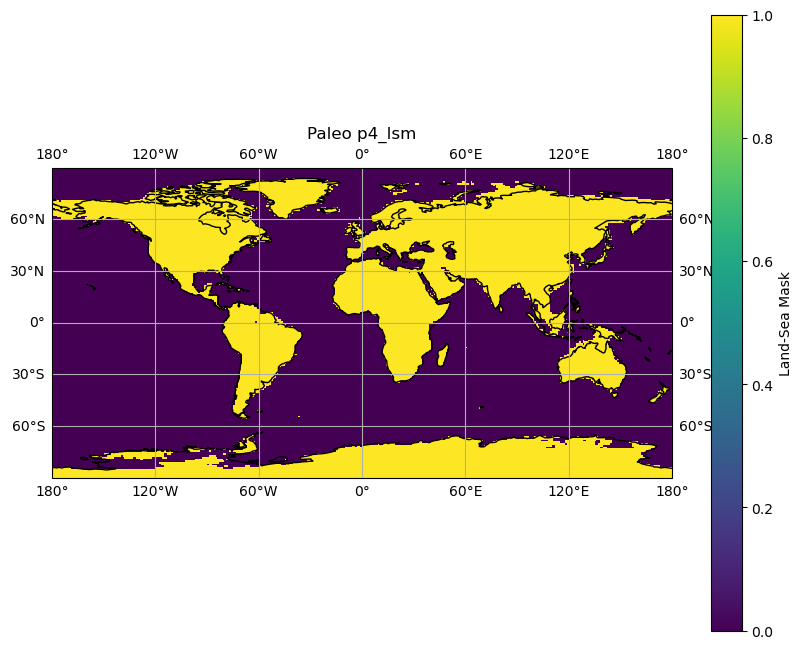

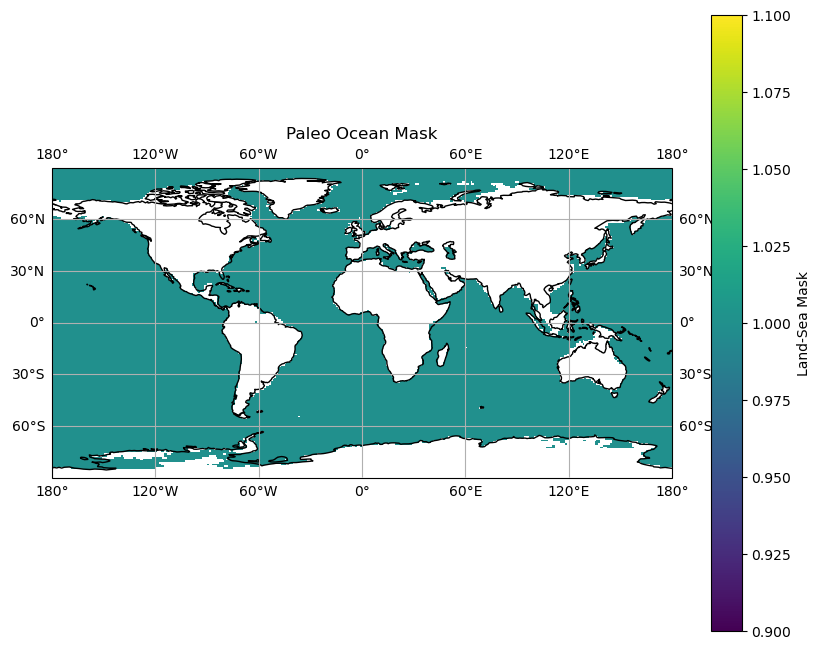

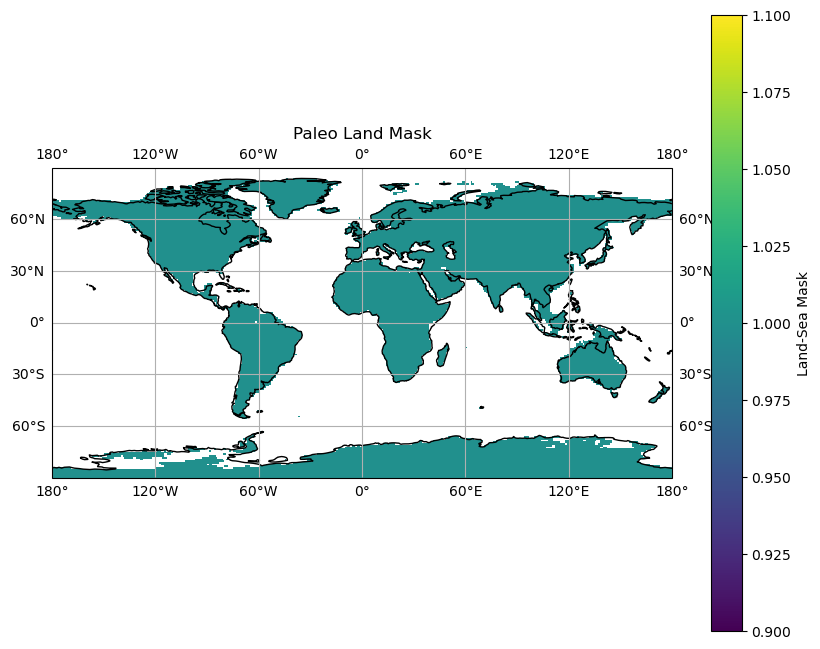

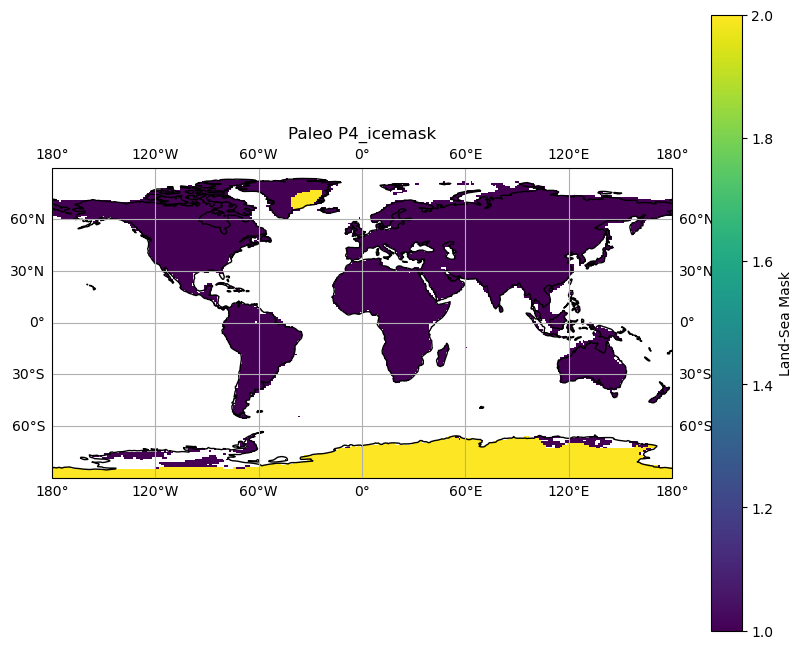

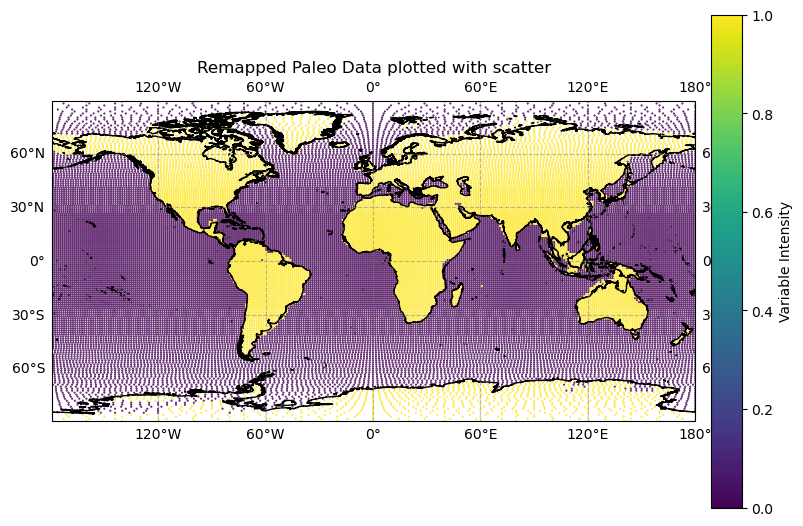

In [63]:

#-----------------------------------------------------------------------------
# Main Program
#-----------------------------------------------------------------------------

if __name__ == '__main__':
    '''
    Main program in which the tool configuration and function calls are located
    Please configure as needed.
    '''

    #====================#
    # Code configuration #
    #====================#
    
    verbose=True
    
    # Truncation number of desired OpenIFS grid. 
    res_num = 159

    # Choose type of trucation. linear or cubic-octahedral
    truncation_type = 'linear'

    # OpenIFS experiment name. This 4 digit code is part of the name of the
    # ICMGG????INIT file you got from EMCWF
    exp_name_oifs = 'abda'#default for cubic-octahedral
    # I have not yet found a way to determine automatically the number of
    # fields in the ICMGG????INIT file. Set it correctly or stuff will break!
    num_fields = 50

    # Name of ocean model grid. 
    grid_name_oce = 'CORE2'
    cavity = False # Does this mesh have ice cavities?
    # set regular grid for intermediate interpolation. 
    # should be heigher than source grid res.
    interp_res = 'r360x181'
    root_dir = '/work/ab0246/a270092/software/ocp-tool/'
    # Construct the relative path based on the script/notebook's location
    input_path_oce = root_dir+'input/fesom_mesh/'
    fesom_grid_file_path = '/work/ab0246/a270092/input/fesom2/core2/mesh.nc'
    force_overwrite_griddes = True
    
    input_path_full_grid = root_dir+'input/gaussian_grids_full/'
    input_path_oifs = root_dir+'input/openifs_input_default/'
    input_path_runoff = root_dir+'input/runoff_map_default/'

    # Output file directories.
    output_path_oifs = root_dir+'output/openifs_input_modified/'
    output_path_runoff = root_dir+'output/runoff_map_modified/'
    output_path_oasis = root_dir+'output/oasis_mct3_input/'
    
    # Configuration of optional paleoclimate modifications
    do_paleo = True
    
    paleo_input_path = '/work/ab0246/a270179/runtime/input/PRISM4/PRISM4D/'
    paleo_lon_name = 'lon'
    paleo_lat_name = 'lat'
    
    paleo_lsm_filename = 'Plio_enh_LSM_v1.0.nc'
    paleo_lsm_var_name = 'p4_lsm'
    
    paleo_ice_filename = 'Plio_enh_icemask_v1.0.nc'
    paleo_ice_var_name = 'P4_icemask'

    
    # Find working directory
    dir_path = root_dir

    # Input file directories. Place files in appropriate subfolders or modify
    if truncation_type == 'cubic-octahedral':
        input_path_reduced_grid = root_dir+'input/gaussian_grids_octahedral_reduced/'
    elif truncation_type == 'linear':
        input_path_reduced_grid = root_dir+'input/gaussian_grids_linear_reduced/'
    else:
        sys.exit('truncation type not recognized')



    
    #====================#
    # Code executation   #
    #====================#

    center_lats, center_lons, \
    crn_lats, crn_lons, \
    gridcell_area, lons_list, \
    NN = generate_coord_area(res_num,
                             input_path_reduced_grid, input_path_full_grid,
                             truncation_type,exp_name_oifs=exp_name_oifs,verbose=verbose)
    
    fesom_grid_sorted = read_fesom_grid(input_path_oce ,grid_name_oce, fesom_grid_file_path ,interp_res, 
                                      cavity=cavity, force_overwrite_griddes=force_overwrite_griddes, 
                                      verbose=verbose)
    
    lsm_binary_a,lsm_binary_l,lsm_binary_r, gribfield_mod = process_lsm(res_num, input_path_oifs, output_path_oifs,
                             exp_name_oifs, grid_name_oce, num_fields,
                             fesom_grid_sorted, lons_list,
                             center_lats, center_lons, crn_lats, crn_lons, 
                             gridcell_area, verbose=verbose)
    if do_paleo:
        paleo_lsm, paleo_lsm_lat, paleo_lsm_lon  = read_paleo(paleo_input_path+paleo_lsm_filename, 
                                                              paleo_lsm_var_name, paleo_lat_name, 
                                                              paleo_lon_name, verbose=verbose)
        paleo_land, paleo_ocean = split_paleo_lsm(paleo_lsm, paleo_lsm_lat, paleo_lsm_lon, verbose=verbose)
        paleo_ice, paleo_ice_lat, paleo_ice_lon = read_paleo(paleo_input_path+paleo_ice_filename, 
                                                             paleo_ice_var_name, paleo_lat_name, 
                                                             paleo_lon_name, verbose=verbose)
        paleo_lsm_remapped = remap_paleo_to_openifs(paleo_lsm, paleo_lsm_lat, paleo_lsm_lon, 
                                                    center_lats, center_lons, res_num, verbose=verbose)

    
    '''write_oasis_files(res_num,
                      output_path_oasis, grid_name_oce,
                      center_lats, center_lons, crn_lats, crn_lons, gridcell_area,
                      lsm_binary_a, lsm_binary_l, lsm_binary_r, NN, input_path_runoff,verbose=verbose)
    
    plotting_lsm(res_num, lsm_binary_l, lsm_binary_a, center_lats, center_lons,verbose=verbose)

    lons, lats = modify_runoff_map(res_num, input_path_runoff, output_path_runoff,
                                   grid_name_oce, manual_basin_removal,verbose=verbose)

    modify_runoff_lsm(res_num, grid_name_oce, manual_basin_removal, lons, lats,
                      output_path_oasis,verbose=verbose)'''
